In [1]:
%matplotlib inline


import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
import cv2

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
data=np.load('flatland_train.npz')

In [3]:
model=load_model("model (8).h5")

Pagrindinio modelio architektūra

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 16)        0

In [8]:
X=data['X']
y=data['y']

In [9]:
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255

In [6]:
X = np.expand_dims(X, (-1))


In [10]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=42)

Funkcijos duomenų augmentacijai

In [53]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range = 0.3,
)

#Generuoti data augmented batchus

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 256)  #images to generate in a batch


#augmented_x_train = []

#for i in range(len(X_train)):
    # Apply augmentation to each image in x_train
    #augmented_image = train_datagen.random_transform(X_train[i])
    #augmented_x_train.append(augmented_image)

#augmented_x_train = np.array(augmented_x_train)

In [ ]:
plt.imshow(augmented_x_train[1], cmap='gray')
plt.axis('off')
plt.show()

Pavyzdys, kaip pakeičiamas paveikslėlis

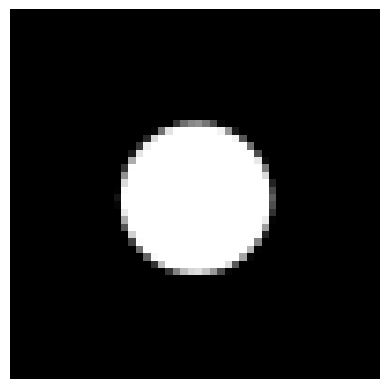

In [ ]:
plt.imshow(X_train[1], cmap='gray')
plt.axis('off')
plt.show()

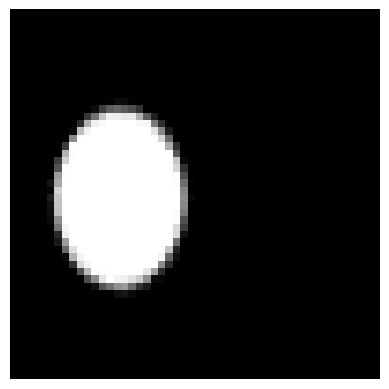

In [ ]:
augmented_image = train_datagen.random_transform(X_train[1])
plt.imshow(augmented_image, cmap='gray')
plt.axis('off')
plt.show()

Modelio architektūra

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), input_shape=[50, 50, 1]),
    MaxPooling2D(pool_size=(2, 2),strides=1),
    layers.Conv2D(32, kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2),strides=1),
    layers.Conv2D(16, kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    Dropout(0.2),
    layers.Dense(16, activation="relu"),#sita pridejau
    Dropout(0.1),
    layers.Dense(5, activation="softmax")])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()


Modelis treniruotas ~400 epochų

In [ ]:
model.fit(train_generator, epochs=400, batch_size=512)

In [17]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

94/94 [==============================] - 2s 21ms/step
Accuracy on test set - 98.40%


In [ ]:
model.save('model.h5')

Student modelio architektūra

In [ ]:
student_model = keras.models.Sequential([
    layers.Conv2D(16, kernel_size=(3, 3), input_shape=[50, 50, 1]),
    MaxPooling2D(pool_size=(3, 3),strides=1),
    MaxPooling2D(pool_size=(4, 4),strides=1),
    layers.Conv2D(6, kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(3, 3),strides=1),
    MaxPooling2D(pool_size=(4, 4),strides=1),
    Dropout(0.25),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(5, activation="softmax")])


student_model.summary()

Funkcijos soft targets generavimui ir distilation loss

In [26]:
temperature=1.8

In [12]:
def soft_targets(inputs):
    logits = model(inputs)
    soft_logits = logits / temperature
    soft_probs = tf.nn.softmax(soft_logits / temperature, axis=-1)
    return soft_probs

In [13]:
def distillation_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)

In [27]:
soft_labels = soft_targets(X_train)

In [ ]:
student_model.compile(optimizer='adam', loss=distillation_loss, metrics=['accuracy'])
student_model.fit(X_train, soft_labels, epochs=40)

In [33]:
pred = student_model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

94/94 [==============================] - 2s 19ms/step
Accuracy on test set - 89.80%


Modelis treniruotas su įvairiais parametrais, skirtingą epochų kiekį, bet didžiausias pasiektas tikslumas ant advanced set - 76%

In [82]:
student_model.save('final_model.h5')